In [42]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from tqdm.auto import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
#torch.cuda.is_available()
device = "cpu"


In [12]:
idx_to_name = [ 'unlabeled','ego vehicle','rectification border', 'out of roi', 'static', 'dynamic','ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence','guard rail' , 'bridge','tunnel','pole', 'polegroup', 'traffic light', 'traffic sign' ,'vegetation', 'terrain', 'sky' ,'person', 'rider', 'car','truck' ,'bus', 'caravan','trailer', 'train' , 'motorcycle','bicycle','license plate']
idx_to_category = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

idx_to_color = [[ 0,  0,  0], [ 0,  0,  0], [  0,  0,  0], [  0,  0,  0],[ 0,  0,  0],[111, 74,  0],[81,  0, 81] ,[128, 64,128],[244, 35,232],
                [250,170,160],[230,150,140],[70, 70, 70],[102,102,156],[190,153,153],[180,165,180],[150,100,100],[150,120, 90],[153,153,153],
                [153,153,153],[250,170, 30],[220,220,  0],[107,142, 35],[152,251,152],[ 70,130,180],[220, 20, 60],[255,  0,  0],[ 0,  0,142],
                [ 0,  0, 70],[ 0, 60,100],[ 0,  0, 90],[  0,  0,110],[ 0, 80,100],[  0,  0,230],[119, 11, 32],[  0,  0,142]]


idx_to_color_np = np.array(idx_to_color)

name_to_category = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2,
                    17 : 3, 18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}

number_of_classes = len(set(name_to_category.values()))

print(f"Number of classes {number_of_classes}")

Number of classes 8


Absolute Path: c:\DML\DML_Project_Group_80\train
Absolute Path: c:\DML\DML_Project_Group_80\val
Absolute Path: c:\DML\DML_Project_Group_80\city_train
Absolute Path: c:\DML\DML_Project_Group_80\city_val
size of training : 2975
size of cityscapes training : 2975
size of validation : 500
size of cityscapes validation : 500
size of input :  (256, 256, 3)
size of mask raw :  (256, 256, 3)
size of classes :  (256, 256)


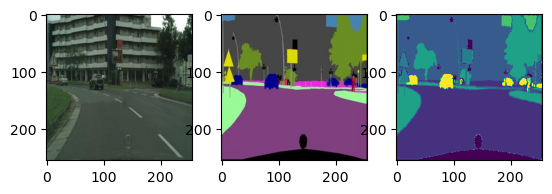

In [13]:
#width = 4
#height = 4
#vis_batch_size = width * height

# get vis_batch_size unique, random indices
#indexes = np.arange(2975)
#indexes = np.random.permutation(indexes)[:vis_batch_size]

from typing import Tuple

# vectorize the operation of getting the name to category for numpy (just a lookup in name_to_category dictionary)
name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)


class CityscapesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_mask_dir = os.path.join(root_dir)
        print("Absolute Path:", os.path.abspath(self.image_mask_dir))
        self.file_list = os.listdir(self.image_mask_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]

        image_mask_path = os.path.join(self.image_mask_dir, file_name)
        img = Image.open(image_mask_path).convert('RGB')

        w, h = img.size
        #print(w)
        #print(h)

        # then split the image into two images (in the middle of width) : input image and color mask (each represented by 3 channels)
        img = np.asarray(img)
        #print(f"Input IMage size {img.shape}")
        raw, mask = img[:, :w//2, :], img[:, w//2:, :]
        #print(raw.shape)
        #print(mask.shape)

        height, width, channels = mask.shape
        #print(height)
        #print(width)
        #print(channels)

        distances = np.sum((mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np)**2, axis=2)
        #print(f"Distance {distances.shape}")
        classes = np.argmin(distances, axis=1).reshape(height, width)
        #print(classes.shape)

        # Optionally map categories to names
        classes = vectorized_cat_mapping(classes)

        #if self.transform:
            #raw_image = self.transform(raw_image)

        return raw, mask , classes

    def visualize(self, idx):
        x, mask_raw , classes = self.__getitem__(idx)
        print("size of input : ", x.shape)
        print("size of mask raw : ", mask_raw.shape)
        print("size of classes : ", classes.shape)
        plt.subplot(1, 3, 1)
        plt.imshow(x)
        plt.subplot(1, 3, 2)
        plt.imshow(mask_raw)
        plt.subplot(1, 3, 3)
        plt.imshow(classes)
        plt.show()


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_path = CityscapesDataset(root_dir='train')
val_path =   CityscapesDataset(root_dir='val')
city_train_path = CityscapesDataset(root_dir='city_train', transform=transform)
city_val_path =   CityscapesDataset(root_dir='city_val', transform=transform)

print(f"size of training : {len(train_path)}")
print(f"size of cityscapes training : {len(city_train_path)}")
print(f"size of validation : {len(val_path)}")
print(f"size of cityscapes validation : {len(city_val_path)}")


# Visualize the first sample
train_path.visualize(0)

In [14]:
X_train, Y_train = [], []
X_val, Y_val = [], []

for index in tqdm(range(len(train_path))):
    X, _, Y = train_path.__getitem__(index)
    X_train.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_train.append(torch.Tensor(Y))

  0%|          | 0/2975 [00:00<?, ?it/s]

In [15]:
for index in tqdm(range(len(val_path))):
    X, _, Y = val_path.__getitem__(index)
    X_val.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_val.append(torch.Tensor(Y))

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
print(f"size of X_train : {len(X_train)} ; Y_train {len(Y_train)}")
print(f"size of X_val : {len(X_val)} ; Y_val {len(Y_val)}")

size of X_train : 2975 ; Y_train 2975
size of X_val : 500 ; Y_val 500


# Normalization of data

In [17]:
class CityScapesDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x , y

Data Normalization using above function

In [18]:
MEAN = [0.485, 0.456, 0.406] # Mean from the image net
STD = [0.229, 0.224, 0.225] # STD from the image net
BATCH_SIZE = 8 # Batch Size


# just normalize the data
preprocess = transforms.Compose([
    transforms.Normalize(mean=MEAN, std=STD),
])

# create the Datasets
train_ds = CityScapesDataset(X_train, Y_train, transform=preprocess)
val_ds = CityScapesDataset(X_val, Y_val, transform=preprocess)

# create the dataloaders
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

# Get one batch from the data loader
iterator = iter(train_dataloader)
batch = next(iterator)

# Check the shape of input tensors in the batch
inputs, labels = batch
print("Shape of inputs:", inputs.shape)
print("Shape of labels:", labels.shape)


Shape of inputs: torch.Size([8, 3, 256, 256])
Shape of labels: torch.Size([8, 256, 256])


# U-NET Network

Testing the above U-NET code

In [19]:
class ConvBlock(nn.Module):
    """apply twice convolution followed by batch normalization and relu. Preserves the width and height of input"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.cn1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.activ1 = nn.ReLU(inplace=True)
        self.cn2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activ2 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.cn1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.cn2(x)
        x = self.bn2(x)
        return self.activ2(x)

class DownScale(nn.Module):
    """Downscaling with maxpool then ConvBlock, transforming an input with (h, w, in_channels) to (h/2, w/2, out_channels)"""
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = ConvBlock(in_channels, out_channels)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.block(x)
        return x
 

class UpScale(nn.Module):
    """apply upscaling and then convolution block transforming an input with (h,w,in_channels) to (2h, 2w, out_channels).
       Forward function also simplifies Unet propagation by taking two inputs : first one from constantly propagating (from upscaling)
       and the second one, which is the output from applying Downscale (first input is upscaled, then concatenated with second)"""
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1) 
        
        # input is (batch, channel, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, start=32, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = ConvBlock(n_channels, start)
        self.down1 = DownScale(start, 2*start)
        self.down2 = DownScale(2*start, 4*start)
        self.down3 = DownScale(4*start, 8*start)
        
        factor = 2 if bilinear else 1
        self.down4 = DownScale(8*start, 16*start // factor)
        
        self.up1 = UpScale(16*start, 8*start // factor, bilinear)
        self.up2 = UpScale(8*start, 4*start // factor, bilinear)
        self.up3 = UpScale(4*start, 2*start // factor, bilinear)
        self.up4 = UpScale(2*start, start, bilinear)
        self.outc = nn.Conv2d(start, n_classes, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    

number_of_classes = len(set(name_to_category.values()))

Test case for above U-Net model

In [37]:

# Example input data
input_data = torch.randn(3, 3, 256, 256)  # Batch size of 8, 3 channels, 256x256 image

# Instantiate the model
in_channels = 3  # Adjust based on your input channels
out_channels = 8  # Adjust based on your output channels
model = Unet(in_channels, out_channels)

# Forward pass
output = model(input_data)

# Print shapes of input and output
print("Shape of input:", input_data.shape)
print("Shape of output:", output.shape)


Shape of input: torch.Size([3, 3, 256, 256])
Shape of output: torch.Size([3, 8, 256, 256])


In [43]:
step_losses = []
epoch_losses = []
epochs = 4
model = Unet(3,number_of_classes)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss() #computes the softmax and loss function

for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    total_pixels = 0
    correct_pixels = 0

    for X, Y in tqdm(train_dataloader, total=len(train_dataloader), leave=False):
        X, Y = X.to(device), Y.to(device)
        Y = Y.long()

        optimizer.zero_grad()
        Y_pred = model(X)
        loss = loss_fn(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())

        # Calculate pixel-wise accuracy
        _, predicted_labels = torch.max(Y_pred, 1)
        correct_pixels += (predicted_labels == Y).sum().item()
        total_pixels += Y.numel()

    accuracy = correct_pixels / total_pixels
    epoch_losses.append(epoch_loss / len(train_dataloader))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_dataloader)}, Accuracy: {accuracy}")


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

KeyboardInterrupt: 

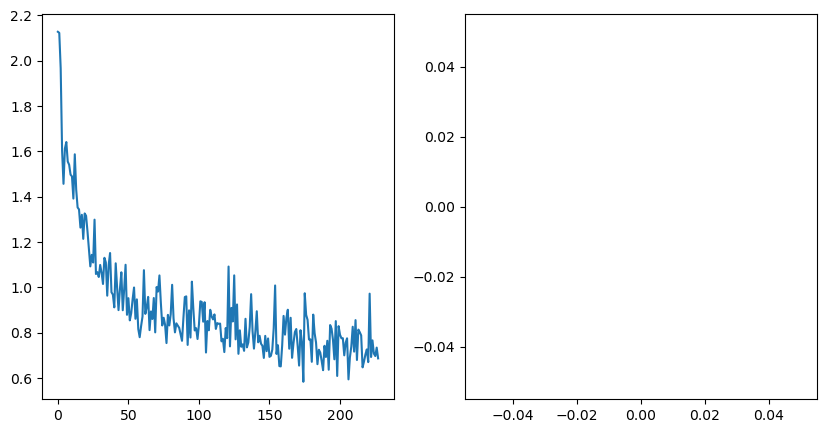

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)